In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error, f1_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report


## Data Import

In [3]:
df = pd.read_csv('train.csv')
df.head(5)

,ID,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,96253,Seu Jorge,"Musicas para Churrasco, Vol.1 (Ao Vivo) (Delux...",Carolina (Ao Vivo),358733,False,0.641,0.880,11,-6.401,0,0.0604,0.1510,0.000761,0.611,0.423,93.000,4,samba,41
1,70417,Chyi Chin,"""1"" (壹)",大約在冬季,231520,False,0.668,0.361,5,-9.710,0,0.0353,0.7950,0.000000,0.246,0.432,73.919,3,mandopop,52
2,66688,Babyboomboom,English and French,"Heads, Shoulders, Knees and Toes (Tête, Epaule...",98386,False,0.786,0.225,9,-16.516,1,0.5730,0.6790,0.000000,0.201,0.658,110.066,4,kids,11
3,51391,Sidhu Moose Wala;DIVINE,Moosetape,Moosedrilla (feat. DIVINE),232173,False,0.709,0.829,0,-5.817,1,0.2450,0.0698,0.000000,0.561,0.654,137.954,4,hip-hop,61
4,95123,Rumbavana,Pa Que Lo Goces Con Ganas,El Capitolio,360320,False,0.786,0.702,0,-6.742,1,0.0456,0.5110,0.000000,0.120,0.696,104.030,4,salsa,37


## Task 1: Exploratory Data Analysis

Exploratory Data Analysis, or EDA, is a crucial phase in data analysis and modeling. It allows us to understand the underlying patterns, identify anomalies, test hypotheses, and check assumptions through summary statistics and graphical representations. The insights gained from EDA guide the preprocessing steps and inform the choice of models and features, ultimately influencing the effectiveness of predictive models. Our EDA focuses on understanding the Spotify dataset's characteristics, specifically through the following questions:

**Questions for EDA**:

1. **Distribution of the Target Variable ("popularity")**: Understanding the distribution helps in assessing how widespread the popularity of songs is across the dataset. This can influence how we handle the target variable in modeling, such as needing transformation or stratification in train-test splits.
2. **Correlations Between Continuous Attributes and the Target Variable**: Identifying these correlations helps in pinpointing which features have more predictive power regarding a song's popularity. Features with stronger correlations might be prioritized in the modeling phase.
3. **Correlations Among Continuous Attributes**: Highlighting these correlations assists in detecting multicollinearity, which can distort the predictive model's performance. Recognizing and addressing multicollinearity is essential in preparing the data for modeling.
4. **Categorical Attributes Analysis**: Understanding the nature of categorical attributes and their potential conversion into dummy variables is crucial for regression models. This analysis helps in feature engineering, impacting the model's complexity and computational efficiency.



### Question 1: What is the distribution of the target variable "popularity"?

In [4]:
#General Statistical Numbers about the distribution of popularity
print(df['popularity'].describe())

count    91199.000000
mean        33.298644
std         22.312524
min          0.000000
25%         17.000000
50%         35.000000
75%         50.000000
max        100.000000
Name: popularity, dtype: float64


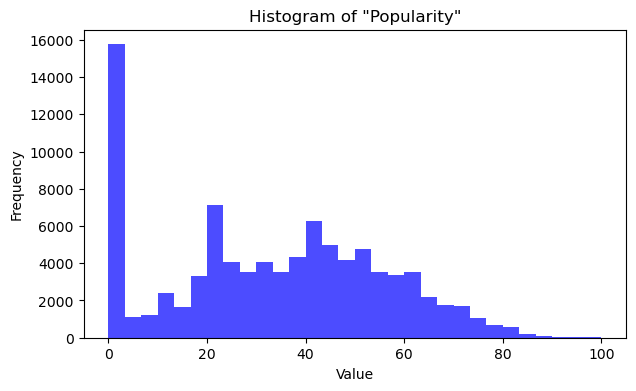

In [5]:
#Histogram of popularity
plt.figure(figsize=(7, 4))
plt.hist(df['popularity'], bins=30, alpha=0.7, color='blue')
plt.title('Histogram of "Popularity"')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

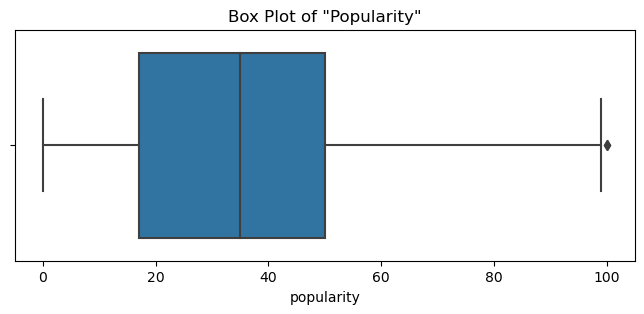

In [6]:
#Box Plot of popularity
plt.figure(figsize=(8, 3))
sns.boxplot(x=df['popularity'])
plt.title('Box Plot of "Popularity"')
plt.show()

**Insights from Question**

- The "popularity" variable shows a skewed distribution with many songs having low popularity. This suggests the need for normalization or transformation when using this target in regression models.
- The presence of outliers indicates the importance of robust scaling or outlier treatment during preprocessing.
- With a mean popularity of 33 and 75% of songs having a popularity of 50 or less, models should be calibrated to predict within this range accurately.

### Question 2: Are there any significant correlations between the continous attributes and the target variable?

In [7]:
#Creating a dataframe with all continous attributes
continuous_features = ['duration_ms', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
                 'popularity']
df_continuous = df[continuous_features]

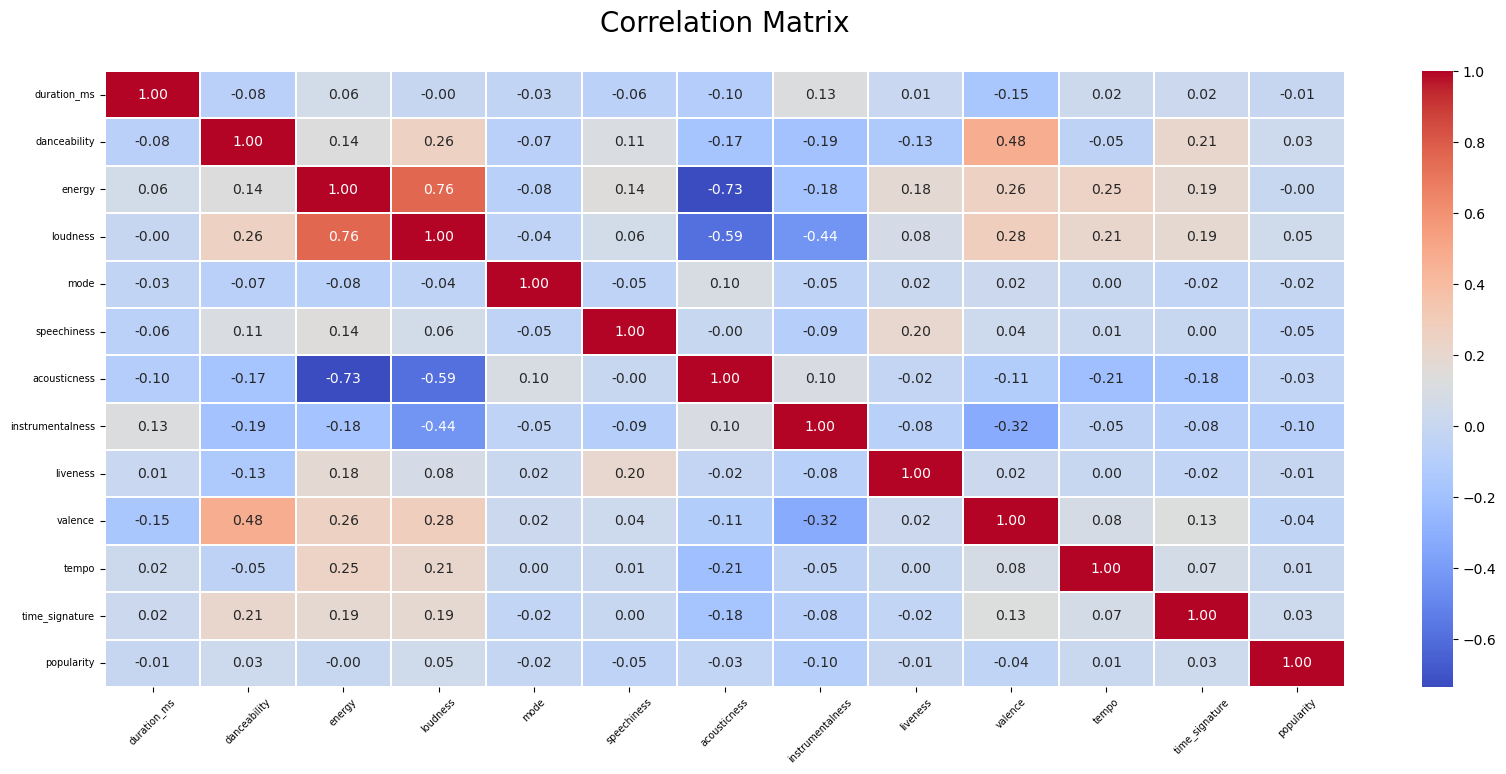

In [8]:
#Creating a correlation matrix

corr = df_continuous.corr()
f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', fmt=".2f", linewidths=.05)

plt.title('Correlation Matrix', fontsize=20, y=1.05)
plt.xticks(fontsize=7, rotation=45)
plt.yticks(fontsize=7)

plt.show()


The correlation matrix shows generally low levels of correlation from all attributes towards the target variable. The highest correlation exists between Instrumentalness and Popularity with a negative correlation of -0.1. 

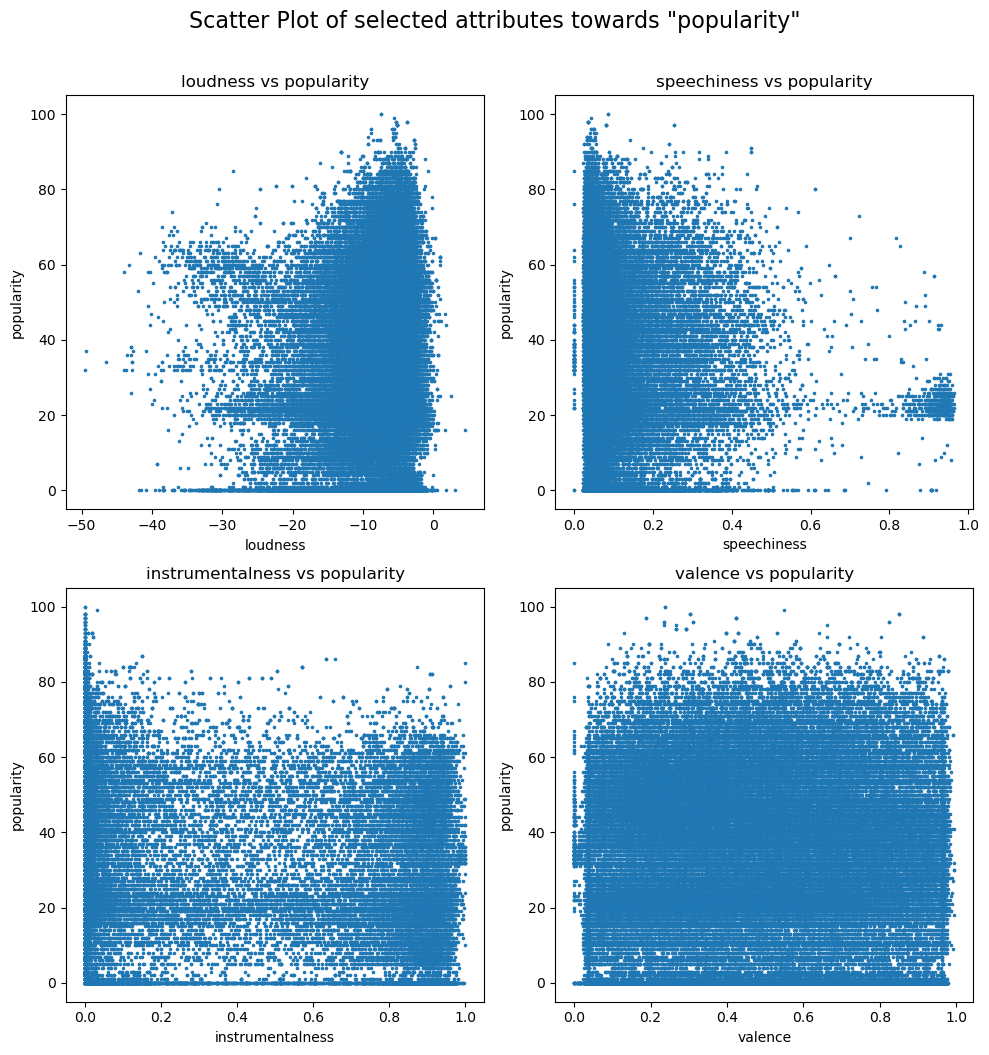

In [9]:
#Exploring loudness, speechiness, instrumentalness & valence and their relation towards popularity

attributes = ["loudness", "speechiness", "instrumentalness", "valence"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, attribute in enumerate(attributes):
    axs[i].scatter(df_continuous[attribute], df_continuous["popularity"], s=2.5)
    axs[i].set_title(f'{attribute} vs popularity')
    axs[i].set_xlabel(attribute)
    axs[i].set_ylabel('popularity')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Scatter Plot of selected attributes towards "popularity"', fontsize=16, y=1.05)
plt.show()

**Insights from Question 2**

- The analysis reveals low to moderate correlations between continuous features and the target variable, highlighting the complexity of predicting song popularity.
- The negative correlation between Instrumentalness and Popularity suggests that less instrumental tracks tend to be more popular, a potential feature for model emphasis.

### Question 3: Are there any significant correlations between the continous attributes?

In [10]:
#Checking for pair-wise correlation

#Printing all attribute pairs with a correlation of >0.5
for col in corr.columns:
    for row in corr.index:
        if col != row and (corr.loc[row, col] > 0.5 or corr.loc[row,col] < -0.5):  # Check for correlation greater than 0.5
            print(f"{row} & {col}: {corr.loc[row, col]}")


loudness & energy: 0.7626133170151342
acousticness & energy: -0.7337905074223686
energy & loudness: 0.7626133170151342
acousticness & loudness: -0.5906657170006351
energy & acousticness: -0.7337905074223686
loudness & acousticness: -0.5906657170006351


In [11]:
#Display the correlation of loudness, acousticness & energy towards the target variable

loudness_popularity_corr = corr.loc['loudness', 'popularity']
acousticness_popularity_corr = corr.loc['acousticness', 'popularity']
energy_popularity_corr = corr.loc['energy', 'popularity']
print(f"Loudness & Popularity Correlation: {loudness_popularity_corr}")
print(f"Acousticness & Popularity Correlation: {acousticness_popularity_corr}")
print(f"Energy & Popularity Correlation: {energy_popularity_corr}")

Loudness & Popularity Correlation: 0.05028210959315112
Acousticness & Popularity Correlation: -0.02616675168485298
Energy & Popularity Correlation: -7.455644632490688e-05


In [12]:
#Calculating VIF scores

vif_data = pd.DataFrame()
vif_data["Feature"] = df_continuous.columns
vif_data["VIF"] = [variance_inflation_factor(df_continuous.values, i) for i in range(df_continuous.shape[1])]

print(vif_data)

             Feature        VIF
0        duration_ms   5.624038
1       danceability  16.310980
2             energy  23.791244
3           loudness   9.244710
4               mode   2.779295
5        speechiness   1.853277
6       acousticness   3.981906
7   instrumentalness   1.839884
8           liveness   2.568854
9            valence   6.804178
10             tempo  17.316117
11    time_signature  54.397016
12        popularity   3.264089


**Insights from Question 3**

- The strong three-way correlation between Loudness, Energy, and Acousticness (>0.5) indicates potential multicollinearity between these attributes. To mitigate this, it may be advisable to remove two attributes of this triple. Acousticness and Energy are being removed, keeping Loudness due to its stronger correlation with the target variable.
- The high VIF score (>10) danceability, energy, tempo and time_signature also indicates high multicollinearity between these attributes and all other attributes. Therefore, danceability, tempo and time_signature are dropped as well. 


## Question 4: What kind of categorical attributes do we have and can they be converted to dummy variables for regressions?

In [13]:
#Creating a dataframe of all categorical features

categorical_features = ['artists', 'album_name', 'track_name', 'explicit', 'track_genre']
df_categorical = df[categorical_features]
df_categorical.head(10)

,artists,album_name,track_name,explicit,track_genre
0,Seu Jorge,"Musicas para Churrasco, Vol.1 (Ao Vivo) (Delux...",Carolina (Ao Vivo),False,samba
1,Chyi Chin,"""1"" (壹)",大約在冬季,False,mandopop
2,Babyboomboom,English and French,"Heads, Shoulders, Knees and Toes (Tête, Epaule...",False,kids
3,Sidhu Moose Wala;DIVINE,Moosetape,Moosedrilla (feat. DIVINE),False,hip-hop
4,Rumbavana,Pa Que Lo Goces Con Ganas,El Capitolio,False,salsa
5,Calero LDN;BOXINBOX,Rozando el cielo,Tu veneno,True,spanish
6,The Jayhawks,Rainy Day Music,Save It For A Rainy Day,False,power-pop
7,le Shuuk;Xillions,Goodbye (feat. Xillions),Goodbye (feat. Xillions),False,party
8,Rohan Kamath,Paani,Paani,False,indie
9,NAZAAR,Guru,Guru,False,dubstep


In [14]:
#Printing out how many different entries each line of 
for col in df_categorical.columns:
    print(f"{col} has {df_categorical[col].nunique()} number of different entries")


artists has 27849 number of different entries
album_name has 40600 number of different entries
track_name has 62098 number of different entries
explicit has 2 number of different entries
track_genre has 114 number of different entries


**Insights from Question 4**

- Binary variables like "explicit" can be easily encoded into dummy variables, straightforwardly preparing them for regression analysis.
- With "track_genre" having numerous unique entries, one-hot encoding can initially include this feature, though it might be excluded in more complex models to reduce dimensionality.
- Attributes with a high cardinality, such as "artists", "album_name", and "track_name", are not suitable for one-hot encoding due to the explosion in feature space. Alternative treatments, like feature extraction or dimensionality reduction techniques, may be necessary to include them.

### Final Conclusion & Pre-Processing

Based on our EDA, the following steps are recommended for preprocessing and model preparation:

- Feature Selection: Exclude Acousticness, Energy, and high-cardinality categorical attributes (artists, album_name, track_name, energy, acousticness) to reduce multicollinearity and dimensionality.
- Encoding: Apply one-hot encoding to "explicit" and, with caution, to "track_genre" to prepare these for regression models.
- Outlier Management and Normalization: Given the distribution of the target variable and the presence of outliers, apply appropriate scaling and outlier treatment techniques.

These recommendations aim to streamline the dataset, improve model accuracy, and ensure computational efficiency, laying a solid foundation for predictive modeling.

In [15]:
# Creating final dataframe for regression tasks

#Dropping acousticness, energy, artists, albumn_name, track_name & ID 
columns_to_drop = ['acousticness', 'energy', 'time_signature', 'danceability', 'tempo', 'ID', 'artists', 'album_name', 'track_name']
df_dropped = df.drop(columns = columns_to_drop)

#Hot-Encoding explicit and track_genre
df = pd.get_dummies(df_dropped, columns=['explicit', 'track_genre'])
df.head(5)


 

,duration_ms,key,loudness,mode,speechiness,instrumentalness,liveness,valence,popularity,explicit_False,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,358733,11,-6.401,0,0.0604,0.000761,0.611,0.423,41,1,...,0,0,0,0,0,0,0,0,0,0
1,231520,5,-9.710,0,0.0353,0.000000,0.246,0.432,52,1,...,0,0,0,0,0,0,0,0,0,0
2,98386,9,-16.516,1,0.5730,0.000000,0.201,0.658,11,1,...,0,0,0,0,0,0,0,0,0,0
3,232173,0,-5.817,1,0.2450,0.000000,0.561,0.654,61,1,...,0,0,0,0,0,0,0,0,0,0
4,360320,0,-6.742,1,0.0456,0.000000,0.120,0.696,37,1,...,0,0,0,0,0,0,0,0,0,0


## Task 2: Regression

### 2.1. Model Creation and Fitting

In [31]:
df_regression = df

X = df_regression.drop('popularity', axis=1)
y = df_regression[['popularity']]

#### Ridge Regression

In [32]:
# Set up the pipeline and parameter grid for Ridge Regression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", Ridge())
])

param_grid_lr = {
    'regressor__alpha': [0.1, 1, 10, 100]
}

# Execute GridSearchCV for Ridge Regression
grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_lr.fit(X, y)

# Calculate R^2 and MSE for the best Ridge Regression model
y_pred_lr = grid_search_lr.predict(X)
r2_lr = r2_score(y, y_pred_lr)
mse_lr = mean_squared_error(y, y_pred_lr)

# Print best parameters and metrics for Ridge Regression
print("Ridge Regression Best Parameters:", grid_search_lr.best_params_)
print("R^2:", r2_lr)
print("MSE:", mse_lr)
print("RMSE:", np.sqrt(mse_lr))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Regression Best Parameters: {'regressor__alpha': 100}
R^2: 0.25725226764029463
MSE: 369.77197420903207
RMSE: 19.229455899973665


#### Random Forest

In [33]:
# Set up the pipeline and parameter grid for RandomForestRegressor
pipe_rfr = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor())
])

param_grid_rfr = {
    'regressor__max_depth': [10, 15, 20, 30, 40],
    'regressor__n_estimators': [50, 100, 200]
}

# Execute GridSearchCV for RandomForestRegressor
grid_search_rfr = GridSearchCV(pipe_rfr, param_grid_rfr, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_rfr.fit(X, y)

# Calculate R^2 and MSE for the best RandomForestRegressor model
y_pred_rfr = grid_search_rfr.predict(X)
r2_rfr = r2_score(y, y_pred_rfr)
mse_rfr = mean_squared_error(y, y_pred_rfr)

# Print best parameters and metrics for RandomForestRegressor
print("RandomForestRegressor Best Parameters:", grid_search_rfr.best_params_)
print("R^2:", r2_rfr)
print("MSE:", mse_rfr)
print("RMSE:", np.sqrt(mse_rfr))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarn

RandomForestRegressor Best Parameters: {'regressor__max_depth': 40, 'regressor__n_estimators': 200}
R^2: 0.4449866471490824
MSE: 276.3096731969124
RMSE: 16.62256518100959


#### Neural Network

In [34]:
# Set up the pipeline and parameter grid for MLP Regressor
pipe_nn = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", MLPRegressor())
])

param_grid_nn = {
    'regressor__hidden_layer_sizes': [(200, 70), (150, 100, 50), (120, 80, 40), (100, 50, 32)],
    'regressor__activation': ['tanh', 'relu']
}

# Execute GridSearchCV for MLP Regressor
grid_search_nn = GridSearchCV(pipe_nn, param_grid_nn, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_nn.fit(X, y)

# Calculate R^2 and MSE for the best MLP Regressor model
y_pred_nn = grid_search_nn.predict(X)
r2_nn = r2_score(y, y_pred_nn)
mse_nn = mean_squared_error(y, y_pred_nn)

# Print best parameters and metrics for MLP Regressor
print("MLP Regressor Best Parameters:", grid_search_nn.best_params_)
print("R^2:", r2_nn)
print("MSE:", mse_nn)
print("RMSE:", np.sqrt(mse_nn))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochasti

MLP Regressor Best Parameters: {'regressor__activation': 'relu', 'regressor__hidden_layer_sizes': (100, 50, 32)}
R^2: 0.5172901238564601
MSE: 240.3138725240186
RMSE: 15.50206026707478


### 2.2. Explanation of r2, mse

<u> R2:</u> 

R2 measures how well the independent variables explain the variance in the dependent variable, indicating model fit. An R2 of 1 suggests perfect prediction fit, but it does not guarantee the model's appropriateness or accuracy for prediction. It is calculated by dividing the 


<u> MSE:</u>

The Mean Squared Error (MSE) is a way to measure how far your results are from the target. We take each prediction, measure how far it is from the actual value, square that number (which means multiplying it by itself), then add up all those squared distances, and finally, we find the average. MSE amplifies larger errors because of the squaring before averaging, making it more sensitive to outliers. 

### 2.3. Comparison of the 3 algorithms on r2, mse and rmse and Selection of Best Model


- Compare and contrast the models on standard metrics, including at least R2 and Mean Squared Error (MSE)
- Explain which model is the best and reflect on why you think that is.


The MLP Regressor appears to be the best model based on the provided metrics of R^2 and MSE. It achieved the highest R^2 value (0.517) and the lowest MSE (240.314) compared to the RandomForestRegressor and Ridge Regression models. These metrics suggest that the MLP Regressor is the most effective at explaining the variance in the target variable and minimizing prediction errors.

One possible reason for the MLP Regressor's superior performance could be its ability to capture nonlinear relationships within the data. Neural networks, like the MLP Regressor, are highly flexible models capable of learning complex patterns in the data. Additionally, the chosen hyperparameters for the MLP Regressor, such as the 'relu' activation function and the specific configuration of hidden layers, may have been well-suited for the dataset, contributing to its superior performance.

### 2.4. Predicting song popularity for test.csv

In [35]:
#Pre-Processing of test.csv

#Import file
df_test = pd.read_csv('test.csv')

#Dropping acousticness, energy, artists, albumn_name, track_name & ID 
columns_to_drop = ['acousticness', 'energy', 'time_signature', 'danceability', 'tempo', 'ID', 'artists', 'album_name', 'track_name']
df_test_dropped = df_test.drop(columns = columns_to_drop)

#Hot-Encoding explicit and track_genre
df_test_hot = pd.get_dummies(df_test_dropped, columns=['explicit', 'track_genre'])

In [50]:
#Defining X and estimating the target variable in y
X_new = df_test_hot
y_new_pred = grid_search_nn.best_estimator_.predict(X_new)

In [38]:
#Generating new CSV with ID and popularity 

df_final = pd.DataFrame({
    'id': df_test['ID'],
    'popularity': y_new_pred
})

df_final.to_csv('submission.csv, index=False')

## Task 3: Classification

### Classification Models

In [16]:
#Create new target variable popularity_category and drop popularity
df_classification = df
df_classification['popularity_category'] = pd.qcut(df_classification['popularity'], q=3, labels=False)
df_classification.drop('popularity', axis=1, inplace=True)

In [17]:
#Define X and y
X = df_classification.drop('popularity_category', axis=1)
y = df_classification[['popularity_category']]
train_X_data, test_X_data, train_y_data, test_y_data = train_test_split(X, y, test_size=0.3, random_state=42)
print(y)

       popularity_category
0                        1
1                        2
2                        0
3                        2
4                        1
...                    ...
91194                    0
91195                    1
91196                    0
91197                    1
91198                    2

[91199 rows x 1 columns]


#### Logistic Regression

In [19]:
# Set up the pipeline and parameter grid for Logistic Regression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())
])

param_grid_lr = {
    'classifier__C': [0.001, 0.1, 1, 10, 100], 
    'classifier__max_iter': [20,50, 100, 200]
}

# Execute GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1_macro', verbose=0)
grid_search_lr.fit(train_X_data, train_y_data)

#Predict y values for test set
predictions_lr = grid_search_lr.predict(test_X_data)

# Calculate F1 & Accuracy Scores
f1_lr = f1_score(test_y_data, predictions_lr, average='macro')
accuracy_lr = accuracy_score(test_y_data, predictions_lr)

# Print best parameters and metrics for Logistic Regression
print("Logistic Regression Best Parameters:", grid_search_lr.best_params_)
print("F1: ", f1_lr)
print("Accuracy: ", accuracy_lr)

/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

Logistic Regression Best Parameters: {'classifier__C': 100, 'classifier__max_iter': 20}
F1:  0.6123071711150462
Accuracy:  0.6123172514619883


/Users/beatweichsler/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random Forest Classifier

In [23]:
# Set up the pipeline and parameter grid for Random Forest Classifier
pipe_rfr = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier())
])

param_grid_rfr = {
    'classifier__max_depth': [10,15,20,30,40], 
    'classifier__n_estimators': [50,100,200]
}

# Execute GridSearchCV for Random Forest Classifier
grid_search_rfr = GridSearchCV(pipe_rfr, param_grid_rfr, cv=5, scoring='f1', verbose=1)
grid_search_rfr.fit(train_X_data, train_y_data)

#Predict y values for test set
predictions_rfr = grid_search_rfr.predict(test_X_data)

# Calculate F1 & Accuracy Scores
f1_rfr = f1_score(test_y_data, predictions_rfr, average='macro')
accuracy_rfr = accuracy_score(test_y_data, predictions_rfr)

# Print best parameters and metrics for Random Forest Classifier
print("Random Forest Classifier Best Parameters:", grid_search_rfr.best_params_)
print("F1: ", f1_rfr)
print("Accuracy: ", accuracy_rfr)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

Random Forest Classifier Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}
F1:  0.5104017522033631
Accuracy:  0.5285818713450292


#### MLP Classifier

In [24]:
# Set up the pipeline and parameter grid for MLP Classifier
pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", MLPClassifier())
])

param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(200,70), (150,100,50), (120,80,40), (100,50,30)], 
    'classifier__activation': ['tanh', 'relu']
}

# Execute GridSearchCV for MLP Classifier
grid_search_mlp = GridSearchCV(pipe_rfr, param_grid_rfr, cv=5, scoring='f1', verbose=1)
grid_search_mlp.fit(train_X_data, train_y_data)

#Predict y values for test set
predictions_mlp = grid_search_mlp.predict(test_X_data)

# Calculate F1 & Accuracy Scores
f1_mlp = f1_score(test_y_data, predictions_mlp, average='macro')
accuracy_mlp = accuracy_score(test_y_data, predictions_mlp)

# Print best parameters and metrics for MLP Classifier
print("MLP Classifier Best Parameters:", grid_search_mlp.best_params_)
print("F1: ", f1_mlp)
print("Accuracy: ", accuracy_mlp)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/natalieschlachter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                      

MLP Classifier Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}
F1:  0.5432915587038972
Accuracy:  0.543201754385965


### 2.2. Explain F1 and Accuracy

<u> Accuracy:</u>

Accuracy is one of the most straightforward metrics used in classification problems. It calculates the proportion of correct predictions (both true positives and true negatives) out of all predictions made. In mathematical terms, it is defined as:

Accuracy = Total Number of Correct Predictions / Total Number of Predictions

OR

Accuracy = (TP + TN) / (TP + TN + FP + FN)

-	TP = True Positives: The number of positive instances correctly predicted as positive.
-	TN = True Negatives: The number of negative instances correctly predicted as negative.
-	FP = False Positives: The number of negative instances incorrectly predicted as positive.
-	FN= False Negatives: The number of positive instances incorrectly predicted as negative.

Accuracy is a good measure when the classes are well balanced but can be misleading when dealing with imbalanced classes, as it can be biased towards the majority class.



<u> F1 Score: </u>

The F1 Score is a metric that considers both the precision and the recall of the classification model to compute the score. Precision is the number of true positive results divided by the number of all positive results, including those not identified correctly. Recall, also known as sensitivity, is the number of true positive results divided by the number of all samples that should have been identified as positive. The F1 Score is the harmonic mean of precision and recall, offering a balance between them:

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1 = 2 × ((Precision × Recall) / (Precision + Recall))

The F1 Score ranges from 0 to 1, where a higher value indicates better model performance. It is particularly useful when the costs of false positives and false negatives are very different or when dealing with imbalanced data. The F1 Score helps to ensure that both the model's ability to correctly label positive cases (recall) and its precision in labeling cases as positive are taken into account, making it a more comprehensive measure than accuracy alone in many scenarios.

### 2.3. Compare & Contrast Models 


- Compare and contrast the models on standard metrics, including at least F1 and accuracy - Use a scikit-learn classification report.
- Explain which model/algorithm is the best and reflect on why you think that is.



Classification Report: compare and contrast models on standard metrics (F1 and accuracy)

In [26]:
# Create classification reports for each model
report_mlp = classification_report(test_y_data, predictions_mlp)
report_rfr = classification_report(test_y_data, predictions_rfr)
report_lr = classification_report(test_y_data, predictions_lr)

# Print classification reports
print("MLP Classifier Report:\n", report_mlp)
print("\nRandom Forest Classifier Report:\n", report_rfr)
print("\nLogistic Regression Report:\n", report_lr)

# Compare F1 and accuracy scores
f1_scores = [f1_mlp, f1_rfr, f1_lr]
accuracy_scores = [accuracy_mlp, accuracy_rfr, accuracy_lr]

print("\nF1 Scores:", f1_scores)
print("Accuracy Scores:", accuracy_scores)


MLP Classifier Report:
               precision    recall  f1-score   support

           0       0.65      0.51      0.57      9407
           1       0.53      0.49      0.51      9238
           2       0.49      0.64      0.55      8715

    accuracy                           0.54     27360
   macro avg       0.55      0.55      0.54     27360
weighted avg       0.56      0.54      0.54     27360


Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       0.63      0.51      0.56      9407
           1       0.44      0.78      0.57      9238
           2       0.71      0.28      0.40      8715

    accuracy                           0.53     27360
   macro avg       0.59      0.52      0.51     27360
weighted avg       0.59      0.53      0.51     27360


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.65      9407
           1       0.57      0.64      0

Analyzing the classification reports:

- **MLP Classifier**: Achieves moderate F1-scores and accuracy across all classes. While it demonstrates relatively balanced precision and recall, it may struggle to distinguish between classes, leading to a moderate overall performance.

- **Random Forest Classifier**: Shows varying performance across classes, with lower precision and recall for some classes compared to others. This suggests potential difficulties in accurately predicting certain classes, resulting in a lower overall F1-score and accuracy.

- **Logistic Regression**: Exhibits the highest F1-score and accuracy among the models, with relatively balanced precision and recall across classes. It demonstrates the most consistent performance across all classes, leading to the highest overall F1-score and accuracy.

Based on these findings, the **Logistic Regression** model appears to be the best-performing algorithm for this classification task. Its ability to provide a more consistent and accurate classification across all classes, as reflected in the higher F1-score and accuracy, suggests its superiority over the MLP Classifier and Random Forest Classifier.

The superiority of Logistic Regression may be attributed to its simplicity, interpretability, and effectiveness in handling linearly separable data. Additionally, the chosen hyperparameters, such as 'C' and 'max_iter', may have been well-tuned for this dataset, contributing to its superior performance.